## That SQL Problem that kept me up all night...

I was losing sleep over this problem which is trivial to solve - so I created a repository showing a solution. Test anxiety... It's the reason I've been reluctant to pursue grad school.

SQLite doesn't support datetime type very well or have Rank - but it was the easiest way to transfer the data for these mockup data structures without worrying about special drivers, credential files or SSH Keys.

* https://www.sqlite.org/cli.html
* https://www.dataquest.io/blog/python-pandas-databases/
* https://www.sqlite.org/lang_datefunc.html
* https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python

##### Let's start by just testing the connection.

In [107]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("workorders.db")
c = conn.cursor()

c.execute('SELECT * FROM work_orders')
print(c.fetchone())

('W0001', '5', '2018-05-01')


##### Now just test a basic query

In [108]:
# Let's Write the Query
query = """
         Select *
         FROM 
         work_order_history
         
         """

# And Run it with DataFramees because it formats the Jupyter Printing Automatically - rather than JSON
df_q = pd.read_sql(query, conn, index_col='work_order_id')
df_q.head(5)

,work_order_new_status_id,work_order_old_status_id,work_order_updated_date
work_order_id,,,
W0001,5,4,2018-05-19
W0002,5,4,2018-05-20
W0003,5,4,2018-05-25
W0006,5,4,2018-05-16
W0008,5,4,2018-05-23


---

##### Let's start with a simpler case - just counting the number of work orders OPENED on a given day.

In [109]:
query = """
         Select D.Date_ID, D.UNIQUE_DATE, IFNULL(WO.work_order_opened_count,0) AS work_order_opened_count
         FROM date_list D
         LEFT JOIN (
             SELECT work_order_opened_date, count(work_order_id) AS work_order_opened_count 
             FROM work_orders 
             GROUP BY work_order_opened_date) WO
         ON D.UNIQUE_DATE = WO.work_order_opened_date
         """

# Run the Query
df_q = pd.read_sql(query, conn, index_col='Date_ID')
df_q.head(5)

,UNIQUE_DATE,work_order_opened_count
Date_ID,,
D20180501,2018-05-01,2
D20180502,2018-05-02,1
D20180503,2018-05-03,1
D20180504,2018-05-04,2
D20180505,2018-05-05,1


##### Perfect! Okay, let's show how Work_Order_History can be queried to get the latest status

This is how you would populate work_orders.work_order_current_status_id in the firest place.

In [221]:
query = """
             SELECT work_order_id, work_order_new_status_id, MAX(work_order_updated_date) AS Last_Updated
             FROM work_order_history
             GROUP BY work_order_id

         """

# Run the Query
df_q = pd.read_sql(query, conn, index_col='work_order_id')
df_q.head(5)

,work_order_new_status_id,Last_Updated
work_order_id,,
W0001,5,2018-05-19
W0002,5,2018-05-20
W0003,5,2018-05-25
W0004,4,2018-05-13
W0005,4,2018-05-25


##### Of course, the goal wasn't to find the max status date, it was to find the date at which a particular Work Order was in a given status.

Also important here, I don't know if a work order can regress - IE, a flaw is found in a part so the order status is set backwards by one step, only to progress again late. Stage 4 -> Stage 3 -> Stage 4

AND - if a status changes by two+ steps in a single day, where you count it? At it's highest step? Where it was at midnight?

MOREOVER - you need to check if a given date is IN BETWEEN any two status changes for a single work order.

work_order_id	work_order_new_status_id	work_order_old_status_id	work_order_updated_date
W0001	5	4	5/19/2018
W0001	4	3	5/16/2018


In [111]:
query = """  SELECT *
             FROM work_order_history
             WHERE work_order_id = 'W0001'
         """
df_q = pd.read_sql(query, conn, index_col='work_order_id')
df_q

,work_order_new_status_id,work_order_old_status_id,work_order_updated_date
work_order_id,,,
W0001,5,4,2018-05-19
W0001,4,3,2018-05-16
W0001,3,2,2018-05-08
W0001,2,1,2018-05-07
W0001,1,,2018-05-01


If the date were to be **5/17/2018** it should return the fact that this budget was in status 4, since the last event before 5/17 was on 5/16. The event on 5/19 hadn't happened yet, so  it should still be in Status 4 rather than Status 5 for the count on that particular day.

So to get around this - and to make sure we have every single day and work order accounted for - we need to crossjoin the table so that every single date and every single work order number is represented.

In [112]:
query = """  
             SELECT * FROM
                 (SELECT *
                 FROM date_list D
                 CROSS JOIN (select work_order_id FROM work_orders) WO
                 ) Matrix
             
         """
df_q = pd.read_sql(query, conn, index_col=None)
df_q.head(5)

,Date_ID,UNIQUE_DATE,work_order_id
0,D20180501,2018-05-01,W0001
1,D20180501,2018-05-01,W0002
2,D20180501,2018-05-01,W0003
3,D20180501,2018-05-01,W0004
4,D20180501,2018-05-01,W0005



## Alright, show time!

Let's generate a Temporary Table and do a crossjoin, but we can just do a crossjoin on the history rather than the current work order table because it will still be set complete and it will carry with it all the data from the most recent updates. 

There's probably also an option where you could just join the history table with itself and look for cases where the new status is higher than the old status in the join condition - but that wouldn't be recursive enough to catch cases where the status changed twice in one day or changed back. So instead, going by the most recent and ranking is the smart option.

UNFORTUNATELY - **SQLite does not have the Rank function.** So I've hacked it in the form of a nested subselect with a Count statement. I created a unique identifier for the cross-joined "matrix" table, "Matrix_UID" based on the Date, the Work Order Number and the Days Since the Last Update. Since it's ordered Ascending, the join conditions assigns the Rank accordingly.

Limiting to:

* AND work_order_id in ('W0001', 'W0002')
* AND julianday(UNIQUE_DATE) < julianday("2018-05-10")

Is just for debugging.

In [222]:
# SQLite doesn't have datedif, or Rank so I had to get creative with temporary tables
query = """  

             WITH T_WO_MATRIX AS (
                 SELECT  (Date_ID||"-"||work_order_id||"-"||CAST(datedif as TEXT)) AS Matrix_UID,
                         (Date_ID||"-"||work_order_id) AS Matrix_WO_Date,
                         *
                 FROM (
                     SELECT *, CAST(julianday(UNIQUE_DATE) - julianday(work_order_updated_date) as INT) AS datedif
                     FROM
                         (SELECT *
                         FROM date_list
                         CROSS JOIN (select * FROM work_order_history)
                         ) M
                    ) 
                 WHERE datedif >= 0
                 AND work_order_id in ('W0001', 'W0002')
                 AND julianday(UNIQUE_DATE) < julianday("2018-05-10")
                 ORDER BY work_order_id, UNIQUE_DATE, datedif asc
                 )
            SELECT *,
            (SELECT COUNT()+1 FROM (
                SELECT DISTINCT Matrix_UID 
                FROM T_WO_MATRIX AS M
                WHERE M.Matrix_WO_Date = T_WO_MATRIX.Matrix_WO_Date
                AND M.Matrix_UID < T_WO_MATRIX.Matrix_UID)
            ) AS Rank
            FROM T_WO_MATRIX
            ORDER BY work_order_id, UNIQUE_DATE, datedif asc;
    
         """
df_q = pd.read_sql(query, conn, index_col=None)
df_q.head(15)

,Matrix_UID,Matrix_WO_Date,Date_ID,UNIQUE_DATE,work_order_id,work_order_new_status_id,work_order_old_status_id,work_order_updated_date,datedif,Rank
0,D20180501-W0001-0,D20180501-W0001,D20180501,2018-05-01,W0001,1,,2018-05-01,0,1
1,D20180502-W0001-1,D20180502-W0001,D20180502,2018-05-02,W0001,1,,2018-05-01,1,1
2,D20180503-W0001-2,D20180503-W0001,D20180503,2018-05-03,W0001,1,,2018-05-01,2,1
3,D20180504-W0001-3,D20180504-W0001,D20180504,2018-05-04,W0001,1,,2018-05-01,3,1
4,D20180505-W0001-4,D20180505-W0001,D20180505,2018-05-05,W0001,1,,2018-05-01,4,1
5,D20180506-W0001-5,D20180506-W0001,D20180506,2018-05-06,W0001,1,,2018-05-01,5,1
6,D20180507-W0001-0,D20180507-W0001,D20180507,2018-05-07,W0001,2,1,2018-05-07,0,1
7,D20180507-W0001-6,D20180507-W0001,D20180507,2018-05-07,W0001,1,,2018-05-01,6,2
8,D20180508-W0001-0,D20180508-W0001,D20180508,2018-05-08,W0001,3,2,2018-05-08,0,1
9,D20180508-W0001-1,D20180508-W0001,D20180508,2018-05-08,W0001,2,1,2018-05-07,1,2


Okay - now that we've got the Rank, with a gross, hacky, sluggish solution. Finding the latest update means just picking where Rank=1.

If this was PostGres, it might look something like (PARTITION BY Matrix_ID ORDER BY datedif DESC) and that would have been that.

Now - I'm going to unrestrict this from just work_order_id in ('W0001', 'W0002') and turn it into a view. 

##### Don't bother running this command, the view exists in the schema already so you'll get an error.

In [223]:
# SQLite doesn't have datedif, or Rank so I had to get creative with temporary tables
query = """  
             CREATE VIEW VIEW_ORDER_MATRIX AS
             SELECT * FROM(
                 WITH T_WO_MATRIX AS (
                     SELECT  (Date_ID||"-"||work_order_id||"-"||CAST(datedif as TEXT)) AS Matrix_UID,
                             (Date_ID||"-"||work_order_id) AS Matrix_WO_Date,
                             *
                     FROM (
                         SELECT *, CAST(julianday(UNIQUE_DATE) - julianday(work_order_updated_date) as INT) AS datedif
                         FROM
                             (SELECT *
                             FROM date_list
                             CROSS JOIN (select * FROM work_order_history)
                             ) M
                        ) 
                     WHERE datedif >= 0
                     AND julianday(UNIQUE_DATE) < julianday("2018-06-01")
                     ORDER BY work_order_id, UNIQUE_DATE, datedif asc
                     )
                SELECT *,
                (SELECT COUNT()+1 FROM (
                    SELECT DISTINCT Matrix_UID 
                    FROM T_WO_MATRIX AS M
                    WHERE M.Matrix_WO_Date = T_WO_MATRIX.Matrix_WO_Date
                    AND M.Matrix_UID < T_WO_MATRIX.Matrix_UID)
                ) AS Rank
                FROM T_WO_MATRIX
                ORDER BY work_order_id, UNIQUE_DATE, datedif asc
            ) WHERE Rank=1
         """
c.execute(query)


In [224]:

query = """
         Select *
         FROM 
         VIEW_ORDER_MATRIX
         
         """
# Run 
df_q = pd.read_sql(query, conn, index_col='Matrix_UID')
df_q.head(5)

,Matrix_WO_Date,Date_ID,UNIQUE_DATE,work_order_id,work_order_new_status_id,work_order_old_status_id,work_order_updated_date,datedif,Rank
Matrix_UID,,,,,,,,,
D20180501-W0001-0,D20180501-W0001,D20180501,2018-05-01,W0001,1,,2018-05-01,0,1
D20180502-W0001-1,D20180502-W0001,D20180502,2018-05-02,W0001,1,,2018-05-01,1,1
D20180503-W0001-2,D20180503-W0001,D20180503,2018-05-03,W0001,1,,2018-05-01,2,1
D20180504-W0001-3,D20180504-W0001,D20180504,2018-05-04,W0001,1,,2018-05-01,3,1
D20180505-W0001-4,D20180505-W0001,D20180505,2018-05-05,W0001,1,,2018-05-01,4,1


### Hooray, it works. I've got the latest work order status update list FOR EACH work order id and each day.

** So now it's trivial to get the count **

In [246]:

query = """
         Select UNIQUE_DATE, count(work_order_new_status_id) AS Status_1_Count 
         FROM VIEW_ORDER_MATRIX
         WHERE work_order_new_status_id = 1
         GROUP BY UNIQUE_DATE
         
         """
# Run 
df_q = pd.read_sql(query, conn, index_col=None)
df_q.head(10)

,UNIQUE_DATE,Status_1_Count
0,2018-05-01,2
1,2018-05-02,2
2,2018-05-03,3
3,2018-05-04,5
4,2018-05-05,5
5,2018-05-06,5
6,2018-05-07,6
7,2018-05-08,5
8,2018-05-09,5
9,2018-05-10,7


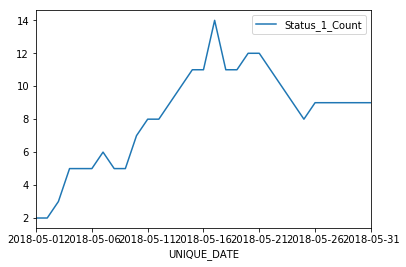

In [244]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
df_q.plot(x = 'UNIQUE_DATE')

,UNIQUE_DATE,Status_1_Count,Status_2_Count
0,2018-05-02,2,1
1,2018-05-03,3,1
2,2018-05-04,5,1
3,2018-05-05,5,2
4,2018-05-06,5,3


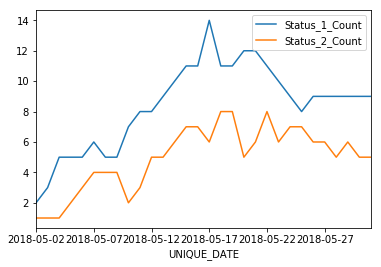

In [245]:
# Now there's most certainly some method to loop through multiple statuses, or just use Python 
# - but this is a pretty long notebook now
query = """
         Select S1.UNIQUE_DATE, Status_1_Count, Status_2_Count
         FROM
         (
             Select UNIQUE_DATE, count(work_order_new_status_id) AS Status_1_Count 
             FROM VIEW_ORDER_MATRIX
             WHERE work_order_new_status_id = 1
             GROUP BY UNIQUE_DATE
        ) S1
         JOIN (
             Select UNIQUE_DATE, count(work_order_new_status_id) AS Status_2_Count 
             FROM VIEW_ORDER_MATRIX
             WHERE work_order_new_status_id = 2
             GROUP BY UNIQUE_DATE
             ) S2
        ON S1.UNIQUE_DATE = S2.UNIQUE_DATE
         
         """
# Run 
df_q = pd.read_sql(query, conn, index_col=None)
plt.figure()
df_q.plot(x = 'UNIQUE_DATE')
df_q.head(5)

#### Now my next trick will be to show how to do this with DataFrames and a few loops, but I spent all evening figuring out an alternative method to find the Rank so that will have to wait for another repo push this weekend.